In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'balanced_test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8133 files belonging to 18 classes.
Using 7320 files for training.
Found 8133 files belonging to 18 classes.
Using 813 files for validation.
Found 1441 files belonging to 18 classes.


In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Let's import the pre-trained model:

In [ ]:
from tensorflow.keras.applications import resnet_v2

resent_model = resnet_v2.ResNet50V2(include_top=False, weights='imagenet', input_shape=(180, 180, 3))

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
resent_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']    

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in resent_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 23519360


# Feature extraction

Let's freeze all the layers in the convolution base:

In [ ]:
resent_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in resent_model.trainable_weights))

# Make sure you have frozen the correct layers
for i, layer in enumerate(resent_model.layers):
    print(i, layer.name, layer.trainable)

This is the number of trainable weights after freezing the conv base: 0
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad Fal

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

Now we define the classifier that we will add on top of the convolutional base:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = resnet_v2.preprocess_input(x)
x = resent_model(x)
x = layers.MaxPooling2D(pool_size=6)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(18, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=1e-2)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0   

**Let's add Keras callbacks:**
*   Early stopping
*   ModelCheckpoint
*   ReduceLROnPlateau

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'ResNet_1_feature_extraction.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]

Train the model:

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
115/115 [==============================] - 2054s 17s/step - loss: 5.9475 - accuracy: 0.0675 - val_loss: 2.8416 - val_accuracy: 0.0763 - lr: 0.0100
Epoch 2/100
115/115 [==============================] - 36s 295ms/step - loss: 2.8887 - accuracy: 0.0563 - val_loss: 2.8773 - val_accuracy: 0.0713 - lr: 0.0100
Epoch 3/100
115/115 [==============================] - 37s 295ms/step - loss: 2.8906 - accuracy: 0.0507 - val_loss: 2.8468 - val_accuracy: 0.0898 - lr: 0.0100
Epoch 4/100
115/115 [==============================] - 36s 297ms/step - loss: 2.8927 - accuracy: 0.0557 - val_loss: 2.8910 - val_accuracy: 0.0652 - lr: 0.0100
Epoch 5/100
115/115 [==============================] - 36s 300ms/step - loss: 2.8898 - accuracy: 0.0548 - val_loss: 2.8878 - val_accuracy: 0.0664 - lr: 0.0100
Epoch 6/100
115/115 [==============================] - 36s 301ms/step - loss: 2.8965 - accuracy: 0.0546 - val_loss: 2.8789 - val_accuracy: 0.0701 - lr: 0.0100
Epoch 7/100
115/115 [=========================

Shows some plots to better evaluate the model:

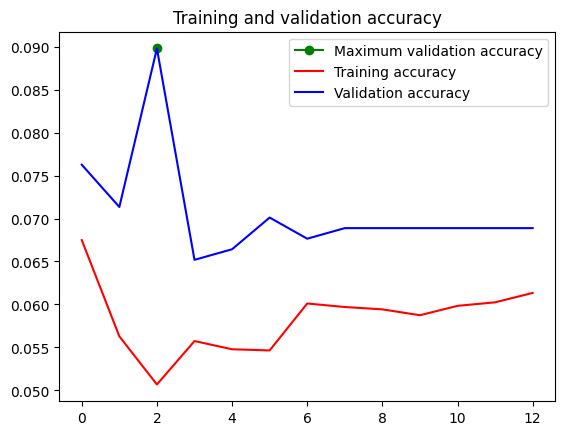

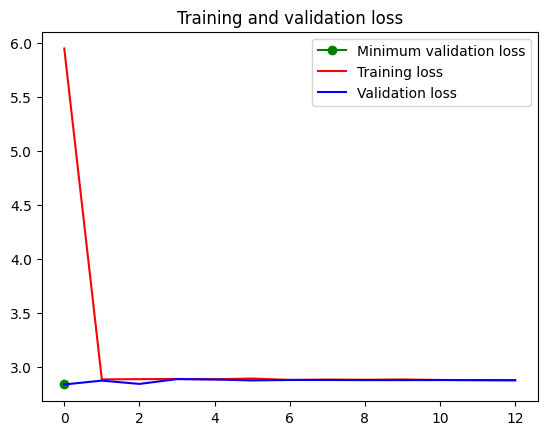

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning conv 5 with lr 10^-5:

In [ ]:
filepath=os.path.join(dir_name, 'ResNet_1_feature_extraction.h5')
model=keras.models.load_model(filepath)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0   

In [ ]:
model.layers[4].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']    

Let's fine tune all the layers above the 154th:

In [ ]:
model.layers[4].trainable = True
set_trainable = False

for layer in model.layers[4].layers[:154]:
  layer.trainable = False
for layer in model.layers[4].layers[154:]:
  layer.trainable = True

In [ ]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers[4].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [ ]:
model.layers[4].summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']    

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 180, 180, 3)      0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, 6, 6, 2048)        23564800  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0   

Let's add the same Keras callbacks as before and train the model:

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'resnet_fine_tuning_moved_version.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]



history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
115/115 [==============================] - 55s 346ms/step - loss: 2.8758 - accuracy: 0.0628 - val_loss: 2.8416 - val_accuracy: 0.0750 - lr: 1.0000e-05
Epoch 2/100
115/115 [==============================] - 42s 348ms/step - loss: 2.8616 - accuracy: 0.0697 - val_loss: 2.8117 - val_accuracy: 0.0923 - lr: 1.0000e-05
Epoch 3/100
115/115 [==============================] - 41s 345ms/step - loss: 2.8536 - accuracy: 0.0738 - val_loss: 2.7763 - val_accuracy: 0.1009 - lr: 1.0000e-05
Epoch 4/100
115/115 [==============================] - 41s 335ms/step - loss: 2.8313 - accuracy: 0.0768 - val_loss: 2.7270 - val_accuracy: 0.1095 - lr: 1.0000e-05
Epoch 5/100
115/115 [==============================] - 41s 341ms/step - loss: 2.8183 - accuracy: 0.0805 - val_loss: 2.6965 - val_accuracy: 0.1181 - lr: 1.0000e-05
Epoch 6/100
115/115 [==============================] - 41s 345ms/step - loss: 2.8110 - accuracy: 0.0824 - val_loss: 2.6719 - val_accuracy: 0.1193 - lr: 1.0000e-05
Epoch 7/100
115/115 [=

Plotting the Training and Validation Loss Curves:

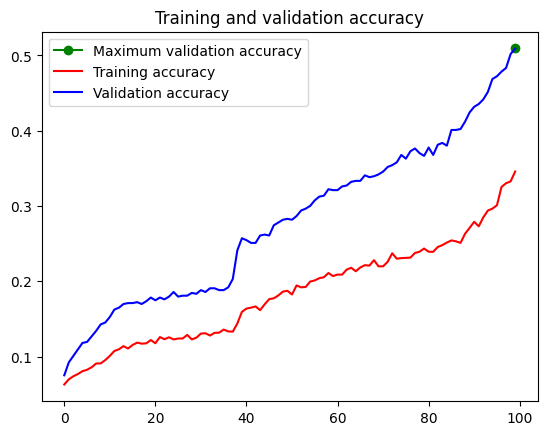

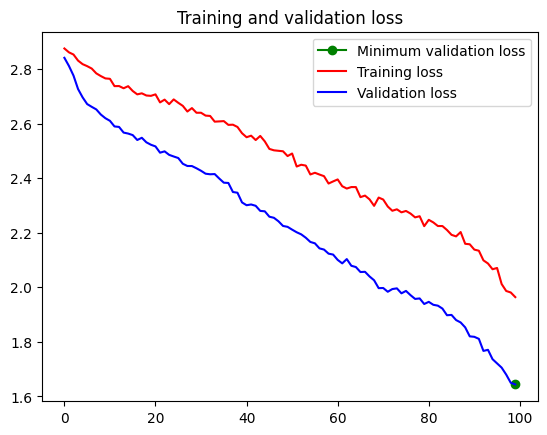

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
115/115 [==============================] - 41s 337ms/step - loss: 1.9397 - accuracy: 0.3556 - val_loss: 1.6038 - val_accuracy: 0.5301 - lr: 1.0000e-05
Epoch 2/100
115/115 [==============================] - 43s 357ms/step - loss: 1.9013 - accuracy: 0.3668 - val_loss: 1.5629 - val_accuracy: 0.5449 - lr: 1.0000e-05
Epoch 3/100
115/115 [==============================] - 41s 331ms/step - loss: 1.8580 - accuracy: 0.3740 - val_loss: 1.5042 - val_accuracy: 0.5621 - lr: 1.0000e-05
Epoch 4/100
115/115 [==============================] - 42s 340ms/step - loss: 1.8484 - accuracy: 0.3822 - val_loss: 1.4765 - val_accuracy: 0.5744 - lr: 1.0000e-05
Epoch 5/100
115/115 [==============================] - 42s 341ms/step - loss: 1.8146 - accuracy: 0.3956 - val_loss: 1.4221 - val_accuracy: 0.5904 - lr: 1.0000e-05
Epoch 6/100
115/115 [==============================] - 40s 332ms/step - loss: 1.7738 - accuracy: 0.4067 - val_loss: 1.3717 - val_accuracy: 0.6187 - lr: 1.0000e-05
Epoch 7/100
115/115 [=

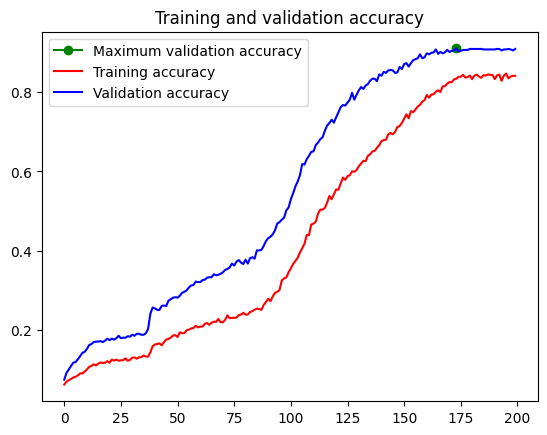

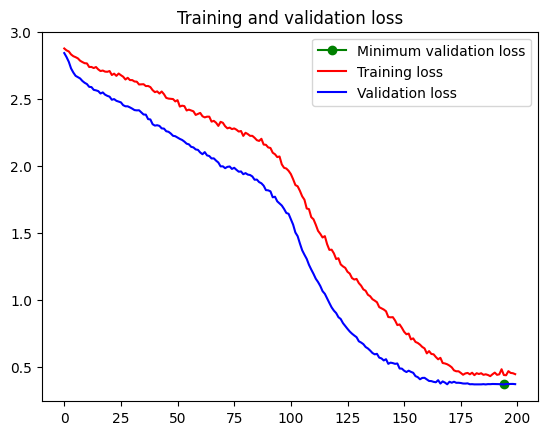

In [ ]:
import matplotlib.pyplot as plt

acc += history.history['accuracy']
val_acc += history.history['val_accuracy']
loss += history.history['loss']
val_loss += history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

23/23 [==============================] - 13s 352ms/step - loss: 1.2019 - accuracy: 0.7488
test_acc: 0.7487855553627014
test_loss: 1.201891541481018


# Confusion matrix

In [ ]:
filepath=os.path.join(dir_name, 'resnet_fine_tuning_moved_version.h5')
model=keras.models.load_model(filepath)

In [ ]:
class_names=test_dataset.class_names

Let's define some functions in order to retrieve the misclassified paintings:

In [ ]:
def get_images_predictions(test_dataset, true_class, predicted_class):

  images = []

  # iterate over the dataset
  for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # compute predictions
    preds = model.predict(image_batch)

    for i in range(len(label_batch)):
      if((label_batch[i][true_class] == 1) and (np.argmax(preds, axis=-1)[i] == predicted_class)):
          images.append(image_batch[i].numpy().astype("uint8"))
          
  return images

In [ ]:
def print_predictions(images, true_class, predicted_class):
  fig = plt.figure(figsize=(9.9, 9.8))
  fig.suptitle("Predicted class: " + class_names[predicted_class]+ "\nCorrect class: "+class_names[true_class])

  for i, image in enumerate(images):
    ax = plt.subplot(4,(len(images)//4)+1,i + 1)
    plt.imshow(images[i])
    ax.axis("off")

  # plt.subplots_adjust(hspace=0.001, wspace=0.5)
  
  plt.tight_layout()
  plt.show()      

In [ ]:
images = get_images_predictions(test_dataset, 8, 17)

2/2 [==============================] - 0s 53ms/step


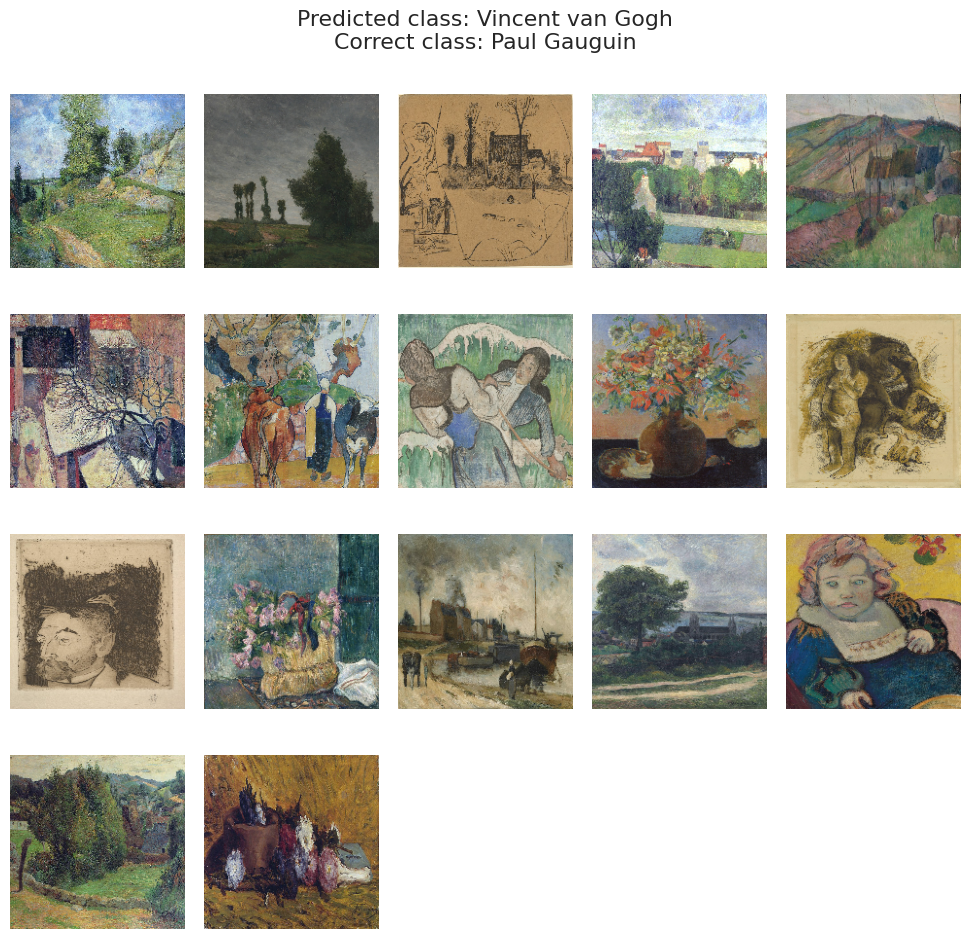

In [ ]:
print_predictions(images, 10, 17)

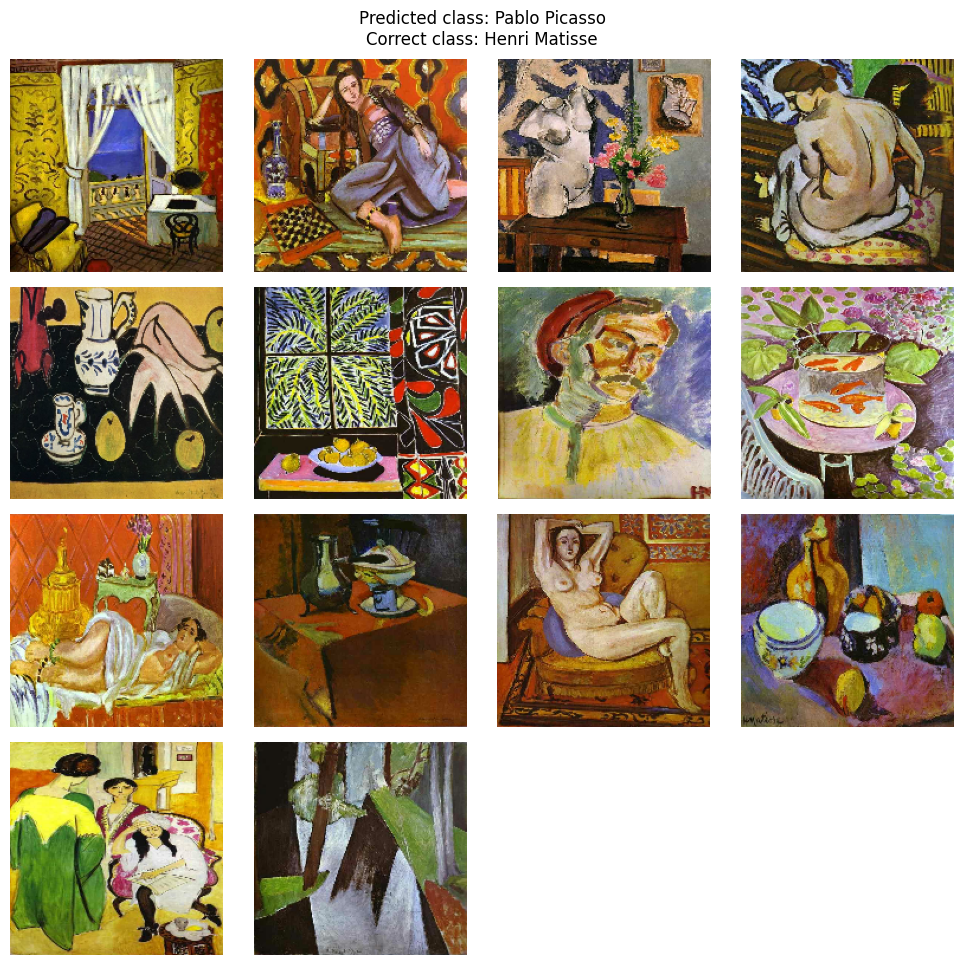

In [ ]:
print_predictions(images, 6, 9)

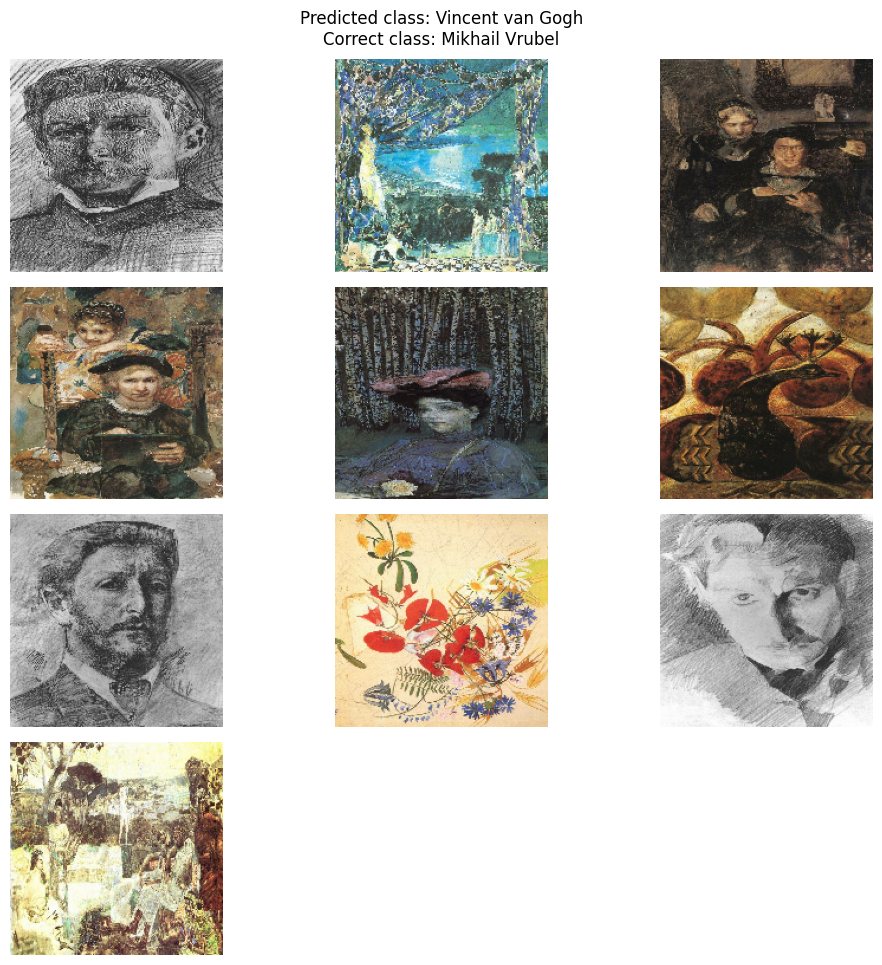

In [ ]:
print_predictions(images, 8, 17)

Function to plot the Confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(rounded_labels, predicted_labels, title):
  cm = confusion_matrix(rounded_labels, predicted_labels)
  fig = plt.figure(figsize = (9,8))
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_title(title)
  sns.set(font_scale=1.1) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 10},cbar = True, cmap='Purples', fmt="d");
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)

  plt.show()

Let's define a function to print a table with the accuracies per class:

In [ ]:
def print_perc_table(class_names, rounded_labels, predicted_labels):

  counter_correct=[0 for i in range(18)]
  counter_errors=[0 for i in range(18)]
  counter_tot=[0 for i in range(18)]
  perc=[0 for i in range(18)]

  for count in range(len(rounded_labels)):
    if rounded_labels[count]==predicted_labels[count]:
      counter_correct[rounded_labels[count]]+=1
    else:
      counter_errors[rounded_labels[count]]+=1

  for i in range(18):
    counter_tot[i]=counter_correct[i]+counter_errors[i]
    perc[i]="{:.2f}".format(counter_correct[i]/counter_tot[i])

  data = np.array([np.array(class_names),np.array(perc)])
  return pd.DataFrame( perc,
    index=class_names,
    columns=["Accuracy"])

In [ ]:
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

In [ ]:
classes_name, classes_size = take_classes_size(test_dir)
print("\nTotal paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  28
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  28
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  47
Rembrandt:  53

Total paintings: 1441


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 1s 563ms/step


In [ ]:
rounded_labels=np.argmax(correct_labels, axis=1)

In [ ]:
#Second one
print_perc_table(class_names, rounded_labels, predicted_labels)

Accuracy
Albrecht Dürer           0.83
Alfred Sisley             0.77
Amedeo Modigliani         0.69
Andy Warhol               0.73
Edgar Degas               0.84
Francisco Goya            0.68
Henri Matisse             0.43
Marc Chagall              0.71
Mikhail Vrubel            0.36
Pablo Picasso             0.64
Paul Gauguin              0.60
Paul Klee                 0.82
Pierre-Auguste Renoir     0.69
Rembrandt                 0.87
Rene Magritte             0.77
Sandro Botticelli         0.52
Titian                    0.49
Vincent van Gogh          0.82

In [ ]:
print_perc_table(class_names, rounded_labels, predicted_labels)

Accuracy
Albrecht Dürer           0.88
Alfred Sisley             0.90
Amedeo Modigliani         0.67
Andy Warhol               0.73
Edgar Degas               0.84
Francisco Goya            0.68
Henri Matisse             0.34
Marc Chagall              0.56
Mikhail Vrubel            0.26
Pablo Picasso             0.76
Paul Gauguin              0.44
Paul Klee                 0.66
Pierre-Auguste Renoir     0.66
Rembrandt                 0.72
Rene Magritte             0.72
Sandro Botticelli         0.55
Titian                    0.55
Vincent van Gogh          0.81

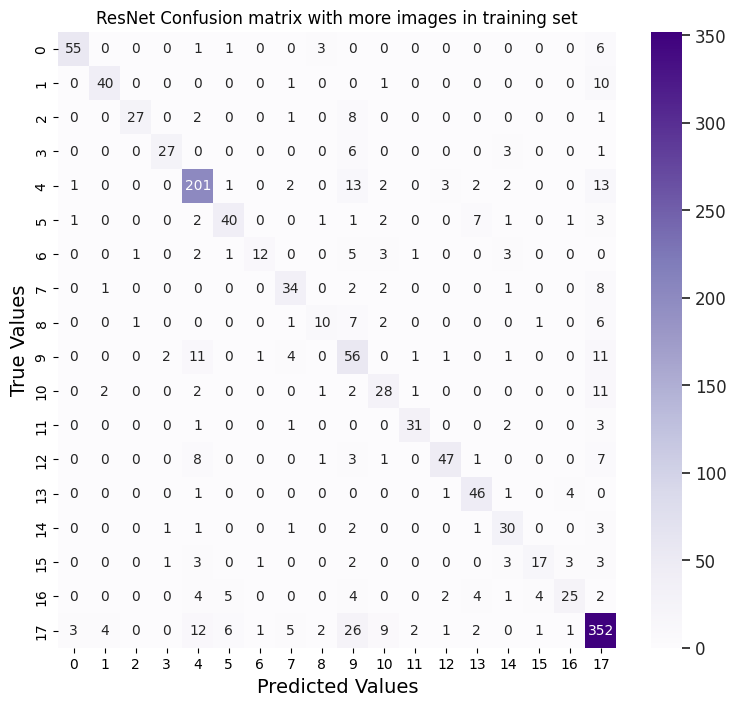

In [ ]:
plot_confusion_matrix(rounded_labels,predicted_labels,"ResNet Confusion matrix with more images in training set")